# AI in Industry project
# Flare prediction
- Ildebrando Simeoni - ildebrando.simeoni@studio.unibo.it
- Davide Femia - davide.femia@studio.unibo.it
- Riccardo Falco - riccardo.falco2@tudio.unibo.it
- Vincenzo Collura - vincenzo.collura2@studio.unibo.it


## Libraries

In [12]:
%load_ext autoreload
%autoreload 2

from Libs.load_data import DataLoader, ClassificationDataLoader, get_dataset_split
import Libs.flares_plot as fplt
from Libs.threshold import get_labels_physic, get_labels_KDE, get_labels_quantile, get_labels_quantile_on_run
from Libs.keras_f1score import f1_m

import numpy as np
import pandas as pd
import os
from itertools import product
from tqdm import tqdm
import matplotlib.pyplot as plt
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, auc, roc_curve

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.initializers import Constant

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataframe building

In [2]:
# TO DO: sostituire tutte le seguenti celle con la funzione di Davide per creare il dataframe con cui traineremo tutti i modelli
data_loader = ClassificationDataLoader(run=100, N=1000, s=0.5, t=0.01, d=0.2, m=1, override=True)
params = data_loader.get_params()
params

{'run': 100,
 'sigma': [0.5],
 'theta': [0.01],
 'mu': [1],
 'delta': [0.2],
 'N': 1000}

In [3]:
Xs, best_labels = data_loader.load_data()

Loading Data


100%|██████████| 100/100 [00:00<00:00, 191.26it/s]


Loading Labels
Labels Loaded


In [4]:
bindexes = data_loader.get_standard_indexes()

dataset_split_params = {
    'window_size': 20, # how large is the window
    'overlap_size': 19, # how many time interval of overlap there is between the windows
    'label_treshold': 1, # how many labels have to be at 1 in the window_size to consider the current window as a flare
    'split_on_run': True, # if True the windows of a run cannot be on different sets
    'shuffle_run': False, # if True shuffles the order of the runs before computing the windows
    'shuffle_window': False, # if True shuffles the order of the windows in the resulting dataframes
    'test_size': 0.3, # size of the test set expressed in percentage
    'val_size': 0.2, # size of the validation set expressed in percentage, considered only if get_validation is True
    'get_validation': True, # if True the output would be train,val,test set, otherwise it would be train,test
    'random_state': 42 # sets the seed for reproducibility
}
df_train, df_val, df_test = get_dataset_split(Xs, best_labels, bindexes, **dataset_split_params)
df_train

,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,...,t_11,t_12,t_13,t_14,t_15,t_16,t_17,t_18,t_19,future_flare
0,1.000000,0.975000,0.998950,1.398585,1.438386,1.689048,1.966308,2.568122,2.375319,4.190594,...,2.845157,4.779448,6.001102,7.958019,6.858917,6.741916,5.873234,5.157005,6.109012,1
1,0.975000,0.998950,1.398585,1.438386,1.689048,1.966308,2.568122,2.375319,4.190594,3.259339,...,4.779448,6.001102,7.958019,6.858917,6.741916,5.873234,5.157005,6.109012,6.309733,1
2,0.998950,1.398585,1.438386,1.689048,1.966308,2.568122,2.375319,4.190594,3.259339,2.845157,...,6.001102,7.958019,6.858917,6.741916,5.873234,5.157005,6.109012,6.309733,6.209758,1
3,1.398585,1.438386,1.689048,1.966308,2.568122,2.375319,4.190594,3.259339,2.845157,4.779448,...,7.958019,6.858917,6.741916,5.873234,5.157005,6.109012,6.309733,6.209758,7.490564,1
4,1.438386,1.689048,1.966308,2.568122,2.375319,4.190594,3.259339,2.845157,4.779448,6.001102,...,6.858917,6.741916,5.873234,5.157005,6.109012,6.309733,6.209758,7.490564,12.011101,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48015,0.149848,0.129055,0.139069,0.121771,0.150383,0.152603,0.149203,0.147091,0.157011,0.183645,...,0.186560,0.249556,0.214295,0.186991,0.225031,0.184697,0.171653,0.164884,0.140189,0
48016,0.129055,0.139069,0.121771,0.150383,0.152603,0.149203,0.147091,0.157011,0.183645,0.198442,...,0.249556,0.214295,0.186991,0.225031,0.184697,0.171653,0.164884,0.140189,0.213669,0
48017,0.139069,0.121771,0.150383,0.152603,0.149203,0.147091,0.157011,0.183645,0.198442,0.186560,...,0.214295,0.186991,0.225031,0.184697,0.171653,0.164884,0.140189,0.213669,0.265009,0
48018,0.121771,0.150383,0.152603,0.149203,0.147091,0.157011,0.183645,0.198442,0.186560,0.249556,...,0.186991,0.225031,0.184697,0.171653,0.164884,0.140189,0.213669,0.265009,0.206403,0


In [5]:
df_val

,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,...,t_11,t_12,t_13,t_14,t_15,t_16,t_17,t_18,t_19,future_flare
0,1.000000,0.975000,0.684336,0.812385,0.750157,0.624754,0.440110,0.433272,0.380983,0.313313,...,0.305069,0.357454,0.300547,0.259115,0.346266,0.361283,0.574706,0.538898,0.638365,0
1,0.975000,0.684336,0.812385,0.750157,0.624754,0.440110,0.433272,0.380983,0.313313,0.193705,...,0.357454,0.300547,0.259115,0.346266,0.361283,0.574706,0.538898,0.638365,0.442731,0
2,0.684336,0.812385,0.750157,0.624754,0.440110,0.433272,0.380983,0.313313,0.193705,0.305069,...,0.300547,0.259115,0.346266,0.361283,0.574706,0.538898,0.638365,0.442731,0.372533,0
3,0.812385,0.750157,0.624754,0.440110,0.433272,0.380983,0.313313,0.193705,0.305069,0.357454,...,0.259115,0.346266,0.361283,0.574706,0.538898,0.638365,0.442731,0.372533,0.324243,0
4,0.750157,0.624754,0.440110,0.433272,0.380983,0.313313,0.193705,0.305069,0.357454,0.300547,...,0.346266,0.361283,0.574706,0.538898,0.638365,0.442731,0.372533,0.324243,0.289455,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20575,0.283386,0.338322,0.529959,0.498035,0.432169,0.439616,0.506125,0.493962,0.474821,0.781296,...,0.662463,0.467084,0.582110,0.470944,0.547727,0.589551,0.598332,0.422484,0.477675,0
20576,0.338322,0.529959,0.498035,0.432169,0.439616,0.506125,0.493962,0.474821,0.781296,0.648389,...,0.467084,0.582110,0.470944,0.547727,0.589551,0.598332,0.422484,0.477675,0.381218,0
20577,0.529959,0.498035,0.432169,0.439616,0.506125,0.493962,0.474821,0.781296,0.648389,0.662463,...,0.582110,0.470944,0.547727,0.589551,0.598332,0.422484,0.477675,0.381218,0.314113,0
20578,0.498035,0.432169,0.439616,0.506125,0.493962,0.474821,0.781296,0.648389,0.662463,0.467084,...,0.470944,0.547727,0.589551,0.598332,0.422484,0.477675,0.381218,0.314113,0.315094,0


In [6]:
df_test

,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,...,t_11,t_12,t_13,t_14,t_15,t_16,t_17,t_18,t_19,future_flare
0,1.000000,0.975000,0.684222,0.795803,1.193148,1.381086,2.121093,2.319864,2.192889,2.211154,...,1.891687,1.617468,1.709285,2.375880,2.700176,2.971325,4.117771,4.067748,5.587491,1
1,0.975000,0.684222,0.795803,1.193148,1.381086,2.121093,2.319864,2.192889,2.211154,1.596551,...,1.617468,1.709285,2.375880,2.700176,2.971325,4.117771,4.067748,5.587491,6.042489,1
2,0.684222,0.795803,1.193148,1.381086,2.121093,2.319864,2.192889,2.211154,1.596551,1.891687,...,1.709285,2.375880,2.700176,2.971325,4.117771,4.067748,5.587491,6.042489,7.320159,1
3,0.795803,1.193148,1.381086,2.121093,2.319864,2.192889,2.211154,1.596551,1.891687,1.617468,...,2.375880,2.700176,2.971325,4.117771,4.067748,5.587491,6.042489,7.320159,6.653984,1
4,1.193148,1.381086,2.121093,2.319864,2.192889,2.211154,1.596551,1.891687,1.617468,1.709285,...,2.700176,2.971325,4.117771,4.067748,5.587491,6.042489,7.320159,6.653984,7.411605,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29395,1.382553,1.619027,1.818016,1.615437,1.476186,1.706824,1.586623,1.379842,1.332406,1.346261,...,1.426310,1.090913,1.017195,0.674936,0.518088,0.450388,0.344671,0.211968,0.254257,1
29396,1.619027,1.818016,1.615437,1.476186,1.706824,1.586623,1.379842,1.332406,1.346261,1.490432,...,1.090913,1.017195,0.674936,0.518088,0.450388,0.344671,0.211968,0.254257,0.336662,1
29397,1.818016,1.615437,1.476186,1.706824,1.586623,1.379842,1.332406,1.346261,1.490432,1.426310,...,1.017195,0.674936,0.518088,0.450388,0.344671,0.211968,0.254257,0.336662,0.385925,1
29398,1.615437,1.476186,1.706824,1.586623,1.379842,1.332406,1.346261,1.490432,1.426310,1.090913,...,0.674936,0.518088,0.450388,0.344671,0.211968,0.254257,0.336662,0.385925,0.303866,1


In [7]:
# number of classes
print('Training set:')
train_counts = df_train['future_flare'].value_counts()
print(train_counts, '\n')
print('validation set:')
val_counts = df_val['future_flare'].value_counts()
print(val_counts, '\n')
print('Test set:')
test_counts = df_test['future_flare'].value_counts()
print(test_counts, '\n')
print('Total:')
total_counts = train_counts.add(val_counts).add(test_counts)
print(total_counts, '\n')


Training set:
0    42598
1     5422
Name: future_flare, dtype: int64 

validation set:
0    18277
1     2303
Name: future_flare, dtype: int64 

Test set:
0    25843
1     3557
Name: future_flare, dtype: int64 

Total:
0    86718
1    11282
Name: future_flare, dtype: int64 



In [8]:
X_train, y_train = df_train.iloc[:,:-1].to_numpy(), df_train.future_flare.to_numpy()
X_val, y_val = df_val.iloc[:,:-1].to_numpy(), df_val.future_flare.to_numpy()
X_test, y_test = df_test.iloc[:,:-1].to_numpy(), df_test.future_flare.to_numpy()
X_train_val, y_train_val = np.vstack((X_train, X_val)), np.hstack((y_train, y_val))
X, y = np.vstack((X_train, X_val, X_test)), np.hstack((y_train, y_val, y_test))
print('X ## Train:', X_train.shape, 'Val:', X_val.shape, 'Test:', X_test.shape, 'Total', X.shape)
print('y ## Train:', y_train.shape, '    Val:', y_val.shape, '    Test:', y_test.shape, '    Total', y.shape)

X ## Train: (48020, 20) Val: (20580, 20) Test: (29400, 20) Total (98000, 20)
y ## Train: (48020,)     Val: (20580,)     Test: (29400,)     Total (98000,)


## Models

### Crossvalidation of simple models

In [9]:
model_lbls = ['dt', 'nb', 'lp', 'svc', 'knn']

class_weights = {0: 1, 1: 5}

# Set the parameters to be explored by the grid for each classifier
tuned_param_dt = [{'max_depth': list(range(1,20))}]
tuned_param_nb = [{'var_smoothing': [10, 1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-07, 1e-8, 1e-9, 1e-10]}]
tuned_param_lp = [{'early_stopping': [True]}]
tuned_param_svc = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],'C': [1, 10, 100, 1000], 'class_weight':[class_weights]},
                   
                   
                   {'kernel': ['linear'], 'C': [1, 10, 100, 1000], 'class_weight':[class_weights]}]
tuned_param_knn =[{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}]


# set the models to be fitted specifying name, estimator and parameter structure
models = {
    'dt': {'name': 'Decision Tree       ',
           'estimator': DecisionTreeClassifier(), 
           'param': tuned_param_dt,
          },
    'nb': {'name': 'Gaussian Naive Bayes',
           'estimator': GaussianNB(),
           'param': tuned_param_nb
          },
    'lp': {'name': 'Linear Perceptron   ',
           'estimator': Perceptron(),
           'param': tuned_param_lp,
          },
    'svc':{'name': 'Support Vector      ',
           'estimator': SVC(), 
           'param': tuned_param_svc
          },
    'knn':{'name': 'K Nearest Neighbor ',
           'estimator': KNeighborsClassifier(),
           'param': tuned_param_knn
          }
}

# scores to be explored
scores = ['f1']

In [10]:
def print_results(model):
    print("Best parameters set found on train_val set:")
    print()
    # if best is linear there is no gamma parameter
    print(model.best_params_)
    print()
    print("Grid scores on train_val set:")
    print()
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    params = model.cv_results_['params']
    for mean, std, params_tuple in zip(means, stds, params):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params_tuple))
    print()
    print("Detailed classification report for the best parameter set:")
    print()
    print("The model is trained on the full train_val set.")
    print("The scores are computed on the full test set.")
    print()
    y_true, y_pred = y_test, model.predict(X_test)
    print(classification_report(y_true, y_pred))
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label=1)
    print('AUC: 'metrics.auc(fpr, tpr))
    print()

In [11]:
results_short = {}
cv_results = []
for score in scores:
    print('='*40)
    print("# Tuning hyper-parameters for %s" % score)
    print()
    s_result = []
    for m in model_lbls:
        print('-'*40)
        print("Trying model {}".format(models[m]['name']))
        clf = GridSearchCV(models[m]['estimator'], models[m]['param'], cv=5,
                           scoring='%s_macro' % score,
                           return_train_score = False,
                           n_jobs = 2, # this allows using multi-cores
                           )
        clf.fit(X_train_val, y_train_val)
        print_results(clf)
        s_result.append(clf)
        results_short[m] = clf.best_score_
    cv_results.append(s_result)
    print("Summary of results for {}".format(score))
    print("Estimator")
    for m in results_short.keys():
        print("{}\t - score: {:5.2f}%".format(models[m]['name'], results_short[m]*100))

# Tuning hyper-parameters for f1

----------------------------------------
Trying model Decision Tree       
Best parameters set found on train set:

{'max_depth': 1}

Grid scores on train_val set:

0.747 (+/-0.018) for {'max_depth': 1}
0.747 (+/-0.018) for {'max_depth': 2}
0.745 (+/-0.018) for {'max_depth': 3}
0.735 (+/-0.014) for {'max_depth': 4}
0.736 (+/-0.015) for {'max_depth': 5}
0.730 (+/-0.011) for {'max_depth': 6}
0.726 (+/-0.018) for {'max_depth': 7}
0.732 (+/-0.028) for {'max_depth': 8}
0.726 (+/-0.021) for {'max_depth': 9}
0.722 (+/-0.016) for {'max_depth': 10}
0.726 (+/-0.022) for {'max_depth': 11}
0.713 (+/-0.023) for {'max_depth': 12}
0.714 (+/-0.027) for {'max_depth': 13}
0.711 (+/-0.028) for {'max_depth': 14}
0.709 (+/-0.026) for {'max_depth': 15}
0.713 (+/-0.028) for {'max_depth': 16}
0.711 (+/-0.024) for {'max_depth': 17}
0.706 (+/-0.024) for {'max_depth': 18}
0.704 (+/-0.026) for {'max_depth': 19}

Detailed classification report for the best parameter set:

The mode

In [ ]:
for s in range(len(cv_results)):
    s_result = cv_results[s]
    for m in range(len(s_result)):
        clf = cv_results[s][m]
        joblib.dump(clf, os.path.join("models", f"{scores[s]}_{model_lbls[m]}.pkl"))
        
        
#load your model for further usage
# clf = joblib.load("model_file_name.pkl")

### CNN

In [12]:
# Standardize Data
scaler = StandardScaler()
scaler.fit(X)
X_train_cnn = scaler.transform(X_train)
X_val_cnn = scaler.transform(X_val)
X_test_cnn = scaler.transform(X_test)
# Make the data uniform to multivariate timeseries
X_train_cnn = X_train_cnn.reshape((X_train_cnn.shape[0], X_train_cnn.shape[1], 1))
X_val_cnn = X_val_cnn.reshape((X_val_cnn.shape[0], X_val_cnn.shape[1], 1))
X_test_cnn = X_test_cnn.reshape((X_test_cnn.shape[0], X_test_cnn.shape[1], 1))
# get automatically the number of classes
num_classes = len(np.unique(y))

In [13]:
def make_model(input_shape, num_classes, output_bias=None):
    if output_bias is not None:
        output_bias = keras.initializers.Constant(output_bias)
    
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    if num_classes==2:
        output_layer = keras.layers.Dense(1, activation="sigmoid", bias_initializer=output_bias)(gap)
    else:
        output_layer = keras.layers.Dense(num_classes, activation="softmax", bias_initializer=output_bias)(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

initial_bias = np.log([train_counts[1]/train_counts[0]])
cnn_model = make_model(input_shape=X_train_cnn.shape[1:], num_classes=num_classes, output_bias=initial_bias)
cnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 100, 64)           256       
                                                                 
 batch_normalization (BatchN  (None, 100, 64)          256       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 100, 64)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 64)           12352     
                                                                 
 batch_normalization_1 (Batc  (None, 100, 64)          256       
 hNormalization)                                             

2023-03-16 18:28:17.639332: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-16 18:28:17.639396: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-16 18:28:17.639422: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (5166cf34c918): /proc/driver/nvidia/version does not exist
2023-03-16 18:28:17.639711: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 re_lu_1 (ReLU)              (None, 100, 64)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 100, 64)           12352     
                                                                 
 batch_normalization_2 (Batc  (None, 100, 64)          256       
 hNormalization)                                                 
                                                                 
 re_lu_2 (ReLU)              (None, 100, 64)           0         
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 25,793
Trainable params: 25,409
Non-trainable params: 384
____

In [15]:
epochs = 500
batch_size = 256
cnn_path = os.path.join("models", "CNN_best_weights.h5")

callbacks = [
    keras.callbacks.ModelCheckpoint(cnn_path, save_weights_only=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.5, patience=20, min_lr=0.0001),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1)
]
if num_classes==2:
    loss = keras.losses.BinaryCrossentropy()
else:
    loss = "sparse_categorical_crossentropy"
cnn_model.compile(
    optimizer="adam",
    loss=loss,
    metrics=[f1_m],
)
cnn_history = cnn_model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(X_val, y_val),
    verbose=1,
)

Epoch 1/500
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
22/22 [==============================] - 7s 179ms/step - loss: 0.4262 - f1_m: 0.2508 - val_loss: 0.4326 - val_f1_m: 0.0484 - lr: 0.0010
Epoch 2/500
22/22 [==============================] - 3s 154ms/step - loss: 0.4082 - f1_m: 0.2922 - val_loss: 0.4307 - val_f1_m: 0.0196 - lr: 0.0010
Epoch 3/500
22/22 [==============================] - 3s 138ms/step - loss: 0.4008 - f1_m: 0.3244 - val_loss: 0.4320 - val_f1_m: 0.0000e+00 - lr: 0.0010
Epoch 4/500
22/22 [==============================] - 3s 147ms/step - loss: 0.4012 - f1_m: 0.3595 - val_loss: 0.4216 - val_f1_m: 0.0151 - lr: 0.0010
Epoch 5/500
22/22 [==============================] - 4s 168ms/step - loss: 0.3910 - f1_m: 0.3562 - val_loss: 0.4212 - val_f1_m: 0.0196 - lr: 0.0010
Epoch 6/500
22/22 [==============================] - 3s

Epoch 53/500
22/22 [==============================] - 3s 142ms/step - loss: 0.3512 - f1_m: 0.4969 - val_loss: 0.4387 - val_f1_m: 0.3022 - lr: 0.0010
Epoch 54/500
22/22 [==============================] - 3s 153ms/step - loss: 0.3473 - f1_m: 0.5409 - val_loss: 0.3862 - val_f1_m: 0.2500 - lr: 0.0010
Epoch 55/500
22/22 [==============================] - 3s 159ms/step - loss: 0.3525 - f1_m: 0.5031 - val_loss: 0.4269 - val_f1_m: 0.1873 - lr: 0.0010
Epoch 56/500
22/22 [==============================] - 3s 139ms/step - loss: 0.3494 - f1_m: 0.5009 - val_loss: 0.3989 - val_f1_m: 0.1826 - lr: 0.0010
Epoch 57/500
22/22 [==============================] - 4s 173ms/step - loss: 0.3491 - f1_m: 0.4831 - val_loss: 0.4157 - val_f1_m: 0.1836 - lr: 0.0010
Epoch 58/500
22/22 [==============================] - 3s 144ms/step - loss: 0.3482 - f1_m: 0.4902 - val_loss: 0.3765 - val_f1_m: 0.2240 - lr: 0.0010
Epoch 59/500
22/22 [==============================] - 4s 183ms/step - loss: 0.3496 - f1_m: 0.5167 - val_lo

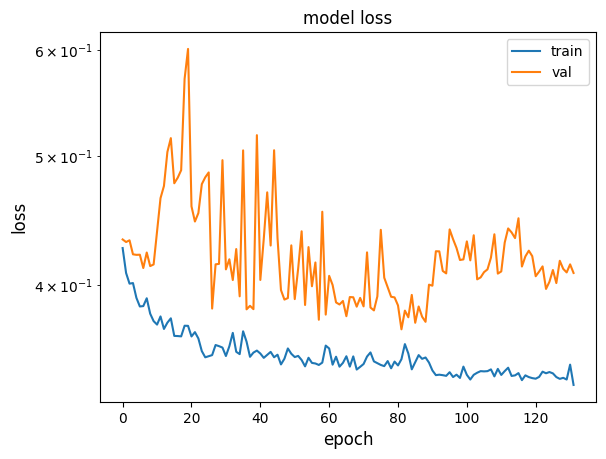

In [16]:
metric = "loss"
plt.figure()
plt.plot(cnn_history.history[metric])
plt.plot(cnn_history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.yscale('log')
plt.show()
plt.close()

In [19]:
cnn_model = make_model(input_shape=X_train_cnn.shape[1:], num_classes=num_classes, output_bias=initial_bias)
cnn_model.load_weights(cnn_path)
y_test_pred_cnn = np.round(cnn_model.predict(X_test_cnn), 0)
test_f1_macro_cnn = f1_score(y_test, y_test_pred_cnn, average='macro')
print("Test F1 Macro", test_f1_macro_cnn)

fpr, tpr, _ = metrics.roc_curve(y_test, y_test_pred_cnn, pos_label=1)
print('AUC: 'metrics.auc(fpr, tpr))

57/57 [==============================] - 1s 8ms/step
Test F1 Macro 0.461069238630557


### LSTM

In [27]:
# define model
def make_lstm(input_shape, output_bias=None):
    if output_bias is not None:
        output_bias = keras.initializers.Constant(output_bias)
    lstm_model = Sequential()
    lstm_model.add(Bidirectional(LSTM(20, activation='relu'), input_shape=input_shape))
    lstm_model.add(Dense(30, activation='relu'))
    lstm_model.add(Dense(10, activation='relu'))
    lstm_model.add(Dense(1, activation='sigmoid',bias_initializer=output_bias))
    return lstm_model

initial_bias = np.log([train_counts[1]/train_counts[0]])
lstm_model = make_lstm((X_train_cnn.shape[1], 1), output_bias=initial_bias)
lstm_model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=[f1_m, 'accuracy'])

print(lstm_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 40)               3520      
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 30)                1230      
                                                                 
 dense_4 (Dense)             (None, 10)                310       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 5,071
Trainable params: 5,071
Non-trainable params: 0
_________________________________________________________________
None


In [28]:
epochs = 20
batch_size = 32
lstm_path = os.path.join("models", "LSTM_best_weights.h5")
# define callbacks
callbacks = [
    ModelCheckpoint(lstm_path, save_weights_only=True, monitor="val_loss"),
    EarlyStopping(monitor="val_loss", patience=3, verbose=1),
]
# fit model
lstm_history = lstm_model.fit(
    X_train_cnn,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(X_val_cnn, y_val),
    verbose=1,
)

Epoch 1/20
1501/1501 [==============================] - 23s 13ms/step - loss: 0.0488 - f1_m: 0.8335 - accuracy: 0.9831 - val_loss: 0.0322 - val_f1_m: 0.0986 - val_accuracy: 0.9843
Epoch 2/20
1501/1501 [==============================] - 18s 12ms/step - loss: 0.0253 - f1_m: 0.8892 - accuracy: 0.9900 - val_loss: 0.0221 - val_f1_m: 0.1185 - val_accuracy: 0.9919
Epoch 3/20
1501/1501 [==============================] - 18s 12ms/step - loss: 0.0210 - f1_m: 0.9122 - accuracy: 0.9919 - val_loss: 0.0189 - val_f1_m: 0.1150 - val_accuracy: 0.9919
Epoch 4/20
1501/1501 [==============================] - 18s 12ms/step - loss: 0.0176 - f1_m: 0.9195 - accuracy: 0.9930 - val_loss: 0.0171 - val_f1_m: 0.1181 - val_accuracy: 0.9930
Epoch 5/20
1501/1501 [==============================] - 18s 12ms/step - loss: 0.0156 - f1_m: 0.9205 - accuracy: 0.9938 - val_loss: 0.0138 - val_f1_m: 0.1164 - val_accuracy: 0.9942
Epoch 6/20
1501/1501 [==============================] - 19s 12ms/step - loss: 0.0143 - f1_m: 0.9182 

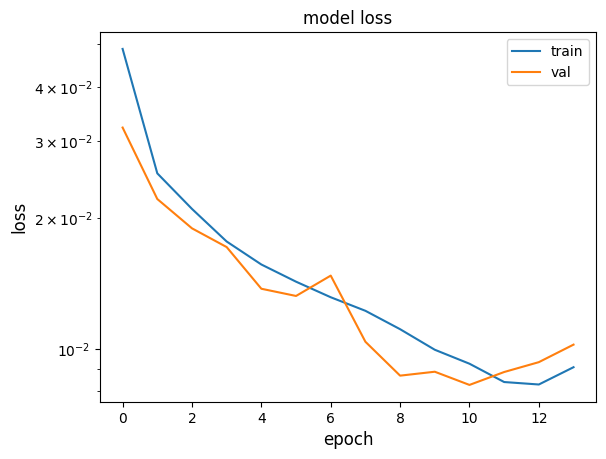

In [29]:
metric = "loss"
plt.figure()
plt.plot(lstm_history.history[metric])
plt.plot(lstm_history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.yscale('log')
plt.show()
plt.close()

In [30]:
lstm_model = make_lstm((X_train_cnn.shape[1], 1))
lstm_model.load_weights(lstm_path)
y_test_pred_lstm = np.round(lstm_model.predict(X_test_cnn), 0)

print("### Evaluation on test set ###")
print("F1 Macro score: %.2f" % (f1_score(y_test, y_test_pred_lstm, average='macro')))
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test, y_test_pred_lstm)
print(result)

fpr, tpr, _ = metrics.roc_curve(y_test, y_test_pred_lstm, pos_label=1)
print('AUC: 'metrics.auc(fpr, tpr))


919/919 [==============================] - 4s 4ms/step
### Evaluation on test set ###
Accuracy: 1.00
F1 Macro score: 0.99
[[26431    50]
 [   40  2879]]


## Extra

### Interpolation vs Extrapolation

The range of data is important when making predictions. If data points are missing from a data range, interpolation and extrapolation are used to predict the values that are in the missing range.

In [31]:
# initialize data loader
data_loader = DataLoader(run=30, N=1000, s=0.5, t=[0.01, 0.1, 0.5, 3], d=0.2, m=1, override=True)
# get the grid
grid_X, grid_y = data_loader.get_grid()
# get params dictionary
params = data_loader.get_params()

grid_X.shape, grid_y.shape

100%|██████████| 30/30 [00:00<00:00, 64.84it/s]


((30, 1, 4, 1, 1, 1000), (30, 1, 4, 1, 1, 1000))

#### LSTM model with multiple all theta parameters

Let's start seeing what is going to happen with training and testing the NN with all the configurations of theta parameters

In [32]:
df_train,df_val,df_test = get_dataset_split(grid_X, grid_y, None, window_size=20, overlap_size=19,
                                            label_treshold=1, split_on_run=True, shuffle_run=False, 
                                            shuffle_window=False, test_size = 0.3, val_size=0.2, 
                                            get_validation=True, random_state=42)
df_train.shape, df_val.shape, df_test.shape

((54880, 21), (27440, 21), (35280, 21))

This cell shows the amounts of class 0 and 1 for each data set

In [33]:
# number of classes
print('Training set:')
print(df_train['future_flare'].value_counts(), '\n')
pos = df_train['future_flare'].value_counts()[0]
true = df_train['future_flare'].value_counts()[1]
print('validation set:')
print(df_val['future_flare'].value_counts(), '\n')
print('Test set:')
print(df_test['future_flare'].value_counts(), '\n')

Training set:
0    35219
1    19661
Name: future_flare, dtype: int64 

validation set:
0    17576
1     9864
Name: future_flare, dtype: int64 

Test set:
0    22742
1    12538
Name: future_flare, dtype: int64 



In [34]:
X_train, y_train = df_train.iloc[:,:-1].to_numpy(), df_train.future_flare.to_numpy()
X_val, y_val = df_val.iloc[:,:-1].to_numpy(), df_val.future_flare.to_numpy()
X_test, y_test = df_test.iloc[:,:-1].to_numpy(), df_test.future_flare.to_numpy()
X = np.vstack((X_train, X_val, X_test))
y = np.hstack((y_train, y_val, y_test))
print('X ## Train:', X_train.shape, 'Val:', X_val.shape, 'Test:', X_test.shape)
print('y ## Train:', y_train.shape, 'Val:', y_val.shape, 'Test:', y_test.shape)

X ## Train: (54880, 20) Val: (27440, 20) Test: (35280, 20)
y ## Train: (54880,) Val: (27440,) Test: (35280,)


Let's construct now the model

In [35]:
initial_bias = Constant([np.log(true/pos)])
# define model
model = Sequential()
model.add(Bidirectional(LSTM(20, activation='relu'), input_shape=(X_train.shape[1], 1)))
model.add(Dense(30, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid',bias_initializer=initial_bias))
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=[f1_m, 'accuracy'])

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 40)               3520      
 nal)                                                            
                                                                 
 dense_9 (Dense)             (None, 30)                1230      
                                                                 
 dense_10 (Dense)            (None, 10)                310       
                                                                 
 dense_11 (Dense)            (None, 1)                 11        
                                                                 
Total params: 5,071
Trainable params: 5,071
Non-trainable params: 0
_________________________________________________________________
None


In [36]:
epochs = 20
batch_size = 32
# define callbacks
callbacks = [
    ModelCheckpoint(
        os.path.join("models", "LSTM_allTheta_checkpoint.h5"), save_weights_only=True, monitor="val_loss"
    ),
    EarlyStopping(monitor="val_loss", patience=3, verbose=1),
]
# fit model
model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(X_val, y_val),
    verbose=1,
)

Epoch 1/20
1715/1715 [==============================] - 23s 12ms/step - loss: 0.2067 - f1_m: 0.8705 - accuracy: 0.9149 - val_loss: 0.2099 - val_f1_m: 0.4946 - val_accuracy: 0.9061
Epoch 2/20
1715/1715 [==============================] - 19s 11ms/step - loss: 0.1292 - f1_m: 0.9205 - accuracy: 0.9470 - val_loss: 0.0900 - val_f1_m: 0.5140 - val_accuracy: 0.9653
Epoch 3/20
1715/1715 [==============================] - 19s 11ms/step - loss: 0.0963 - f1_m: 0.9427 - accuracy: 0.9612 - val_loss: 0.0855 - val_f1_m: 0.5072 - val_accuracy: 0.9638
Epoch 4/20
1715/1715 [==============================] - 19s 11ms/step - loss: 0.0808 - f1_m: 0.9545 - accuracy: 0.9691 - val_loss: 0.0639 - val_f1_m: 0.5246 - val_accuracy: 0.9789
Epoch 5/20
1715/1715 [==============================] - 19s 11ms/step - loss: 0.0723 - f1_m: 0.9601 - accuracy: 0.9726 - val_loss: 0.0851 - val_f1_m: 0.5033 - val_accuracy: 0.9644
Epoch 6/20
1715/1715 [==============================] - 19s 11ms/step - loss: 0.0660 - f1_m: 0.9629 

Validation set results

In [37]:
scores = model.evaluate(X_val, y_val, verbose=0)
y_pred = np.round(model.predict(X_val), 0)

print("### Evaluation on validation set ###")
print("Accuracy: %.2f" % (accuracy_score(y_pred, y_val)))
print("F1 Macro score: %.2f" % (f1_score(y_pred, y_val, average='macro')))
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_val, y_pred)
print(result)

Test results

In [ ]:
scores = model.evaluate(X_test, y_test, verbose=0)
y_pred = np.round(model.predict(X_test), 0)

print("### Evaluation on test set ###")
print("Accuracy: %.2f" % (accuracy_score(y_pred, y_test)))
print("F1 Macro score: %.2f" % (f1_score(y_pred, y_test, average='macro')))
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test, y_pred)
print(result)

#### Interpolation

Same model as before, but now we are fitting only in the dataset coming from the generation with using just the extreme parameters: 

$\theta=0.01$ and $\theta=3$

and a fraction of the other dataset, coming from $\theta=0.1$ and $\theta=0.5$ as test set

In [ ]:
params

In [ ]:
p = 'theta'
theta_train_list     = [0.01, 3]
theta_train_list_idx = [params[p].index(t) for t in theta_train_list]
theta_test_list      = [0.1, 0.5]
theta_test_list_idx  = [params[p].index(t) for t in theta_test_list]

# get the train and validation set, selecting the index for grid given the interpolation assuption
# notice that theta is the third parameter
df_train, df_val, _ = get_dataset_split(grid_X[:,:,theta_train_list_idx,:,:,:], 
                                        grid_y[:,:,theta_train_list_idx,:,:,:], 
                                        None, window_size=20, overlap_size=19,
                                        label_treshold=1, split_on_run=True, shuffle_run=False, 
                                        shuffle_window=False, test_size = 0.3, val_size=0.2, 
                                        get_validation=True, random_state=42)
# get the test set, selecting the index for grid given the interpolation assuption
# notice that theta is the third parameter
_, _, df_test = get_dataset_split(grid_X[:,:,theta_test_list_idx,:,:,:], 
                                  grid_y[:,:,theta_test_list_idx,:,:,:], 
                                  None, window_size=20, overlap_size=19,
                                  label_treshold=1, split_on_run=True, shuffle_run=False, 
                                  shuffle_window=False, test_size = 0.3, val_size=0.2, 
                                  get_validation=True, random_state=42)
df_train.shape, df_val.shape, df_test.shape

In [ ]:
# number of classes
print('Training set:')
print(df_train['future_flare'].value_counts(), '\n')
pos = df_train['future_flare'].value_counts()[0]
true = df_train['future_flare'].value_counts()[1]
print('validation set:')
print(df_val['future_flare'].value_counts(), '\n')
print('Test set:')
print(df_test['future_flare'].value_counts(), '\n')

In [ ]:
X_train, y_train = df_train.iloc[:,:-1].to_numpy(), df_train.future_flare.to_numpy()
X_val, y_val = df_val.iloc[:,:-1].to_numpy(), df_val.future_flare.to_numpy()
X_test, y_test = df_test.iloc[:,:-1].to_numpy(), df_test.future_flare.to_numpy()
X = np.vstack((X_train, X_val, X_test))
y = np.hstack((y_train, y_val, y_test))
print('X ## Train:', X_train.shape, 'Val:', X_val.shape, 'Test:', X_test.shape)
print('y ## Train:', y_train.shape, 'Val:', y_val.shape, 'Test:', y_test.shape)

In [ ]:
initial_bias = Constant([np.log(true/pos)])
# define model
model = Sequential()
model.add(Bidirectional(LSTM(20, activation='relu'), input_shape=(X_train.shape[1], 1)))
model.add(Dense(30, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid',bias_initializer=initial_bias))
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=[f1_m, 'accuracy'])

print(model.summary())

In [ ]:
epochs = 20
batch_size = 32
# define callbacks
callbacks = [
    ModelCheckpoint(
        os.path.join("models", "LSTM_intrpTheta_checkpoint.h5"), save_weights_only=True, monitor="val_loss"
    ),
    EarlyStopping(monitor="val_loss", patience=3, verbose=1),
]
# fit model
model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(X_val, y_val),
    verbose=1,
)

Validation results

In [ ]:
scores = model.evaluate(X_val, y_val, verbose=0)
y_pred = np.round(model.predict(X_val), 0)

print("### Evaluation on validation set ###")
print("Accuracy: %.2f" % (accuracy_score(y_pred, y_val)))
print("F1 Macro score: %.2f" % (f1_score(y_pred, y_val, average='macro')))
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_val, y_pred)
print(result)

Test results

In [ ]:
scores = model.evaluate(X_test, y_test, verbose=0)
y_pred = np.round(model.predict(X_test), 0)

print("### Evaluation on test set ###")
print("Accuracy: %.2f" % (accuracy_score(y_pred, y_test)))
print("F1 Macro score: %.2f" % (f1_score(y_pred, y_test, average='macro')))
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test, y_pred)
print(result)

Results are still similar to the standard case

#### Extrapolation

Same model as before, but now we are fitting only in the dataset coming from the generation without using the extreme parameters: 

$\theta=0.1$ and $\theta=0.5$

In [ ]:
p = 'theta'
theta_train_list     = [0.1, 0.5]
theta_train_list_idx = [params[p].index(t) for t in theta_train_list]
theta_test_list      = [0.01, 3]
theta_test_list_idx  = [params[p].index(t) for t in theta_test_list]

# get the train and validation set, selecting the index for grid given the interpolation assuption
# notice that theta is the third parameter
df_train, df_val, _ = get_dataset_split(grid_X[:,:,theta_train_list_idx,:,:,:], 
                                        grid_y[:,:,theta_train_list_idx,:,:,:], 
                                        None, window_size=20, overlap_size=19,
                                        label_treshold=1, split_on_run=True, shuffle_run=False, 
                                        shuffle_window=False, test_size = 0.3, val_size=0.2, 
                                        get_validation=True, random_state=42)
# get the test set, selecting the index for grid given the interpolation assuption
# notice that theta is the third parameter
_, _, df_test = get_dataset_split(grid_X[:,:,theta_test_list_idx,:,:,:], 
                                  grid_y[:,:,theta_test_list_idx,:,:,:], 
                                  None, window_size=20, overlap_size=19,
                                  label_treshold=1, split_on_run=True, shuffle_run=False, 
                                  shuffle_window=False, test_size = 0.3, val_size=0.2, 
                                  get_validation=True, random_state=42)
df_train.shape, df_val.shape, df_test.shape

In [ ]:
X_train, y_train = df_train.iloc[:,:-1].to_numpy(), df_train.future_flare.to_numpy()
X_val, y_val = df_val.iloc[:,:-1].to_numpy(), df_val.future_flare.to_numpy()
X_test, y_test = df_test.iloc[:,:-1].to_numpy(), df_test.future_flare.to_numpy()
X = np.vstack((X_train, X_val, X_test))
y = np.hstack((y_train, y_val, y_test))
print('X ## Train:', X_train.shape, 'Val:', X_val.shape, 'Test:', X_test.shape)
print('y ## Train:', y_train.shape, 'Val:', y_val.shape, 'Test:', y_test.shape)

Same model as before

In [ ]:
initial_bias = Constant([np.log(true/pos)])
# define model
model = Sequential()
model.add(Bidirectional(LSTM(20, activation='relu'), input_shape=(X_train.shape[1], 1)))
model.add(Dense(30, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid',bias_initializer=initial_bias))
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=[f1_m, 'accuracy'])

print(model.summary())

In [ ]:
epochs = 20
batch_size = 32
# define callbacks
callbacks = [
    ModelCheckpoint(
        os.path.join("models", "LSTM_extrpTheta_checkpoint.h5"), save_weights_only=True, monitor="val_loss"
    ),
    EarlyStopping(monitor="val_loss", patience=3, verbose=1),
]
# fit model
model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(X_val, y_val),
    verbose=1,
)

Validation results

In [ ]:
scores = model.evaluate(X_val, y_val, verbose=0)
y_pred = np.round(model.predict(X_val), 0)

print("### Evaluation on validation set ###")
print("Accuracy: %.2f" % (accuracy_score(y_pred, y_val)))
print("F1 Macro score: %.2f" % (f1_score(y_pred, y_val, average='macro')))
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_val, y_pred)
print(result)

Test results

In [ ]:
scores = model.evaluate(X_test, y_test, verbose=0)
y_pred = np.round(model.predict(X_test), 0)

print("### Evaluation on test set ###")
print("Accuracy: %.2f" % (accuracy_score(y_pred, y_test)))
print("F1 Macro score: %.2f" % (f1_score(y_pred, y_test, average='macro')))
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test, y_pred)
print(result)